In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter, defaultdict
from tqdm import tqdm
import sklearn
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [3]:
def preprocess(df):
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #Question: Do we need to remove all pollutants with suffix '_24h'?
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df
train = preprocess(train)
test = preprocess(test)

In [4]:
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])

In [5]:
def process_one_location(df, location, take_log=True, n_lag=3):
    #build a model for '万柳' first
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[subset.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')
#     subset['location'] = location
    
    #filling missing hours
    subset_augmented = subset.asfreq('h')
    subset_augmented = subset_augmented.interpolate(method = 'linear')
    #before April 2014, there is no extra data. Therefore we only use data after that time
    subset_augmented = subset_augmented.dropna()
    
    if take_log:
        subset_augmented = subset_augmented.apply(lambda x: np.log(x))
        
    subset_augmented = feature_engineering(subset_augmented,n_lag)
    
    subset_augmented =  subset_augmented.dropna()
    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    subset_augmented['target'] = subset_augmented['PM2.5_diff']
    
    subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag):
    
    subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
    subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
    subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(24)
    subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
    subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
    subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(1)
    subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
    subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(1)
    subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
    subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(1)
    
    subset_augmented = create_lag(n_lag,subset_augmented)
    
    subset_augmented = calculate_rolling_stat(subset_augmented)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented):
    col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res):
    for p in ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']:
        res[f'{p}_daily_mean'] = res[p].rolling(24).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24).median()
        res[f'{p}_daily_std'] = res[p].rolling(24).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30).std()
    return res

In [6]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,take_log=False)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])

In [7]:
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,take_log=False)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

In [8]:
corr_data = allTarget.pivot(columns='location')
corr = allTarget.pivot(columns='location').corr()

<AxesSubplot:xlabel='None-location', ylabel='None-location'>

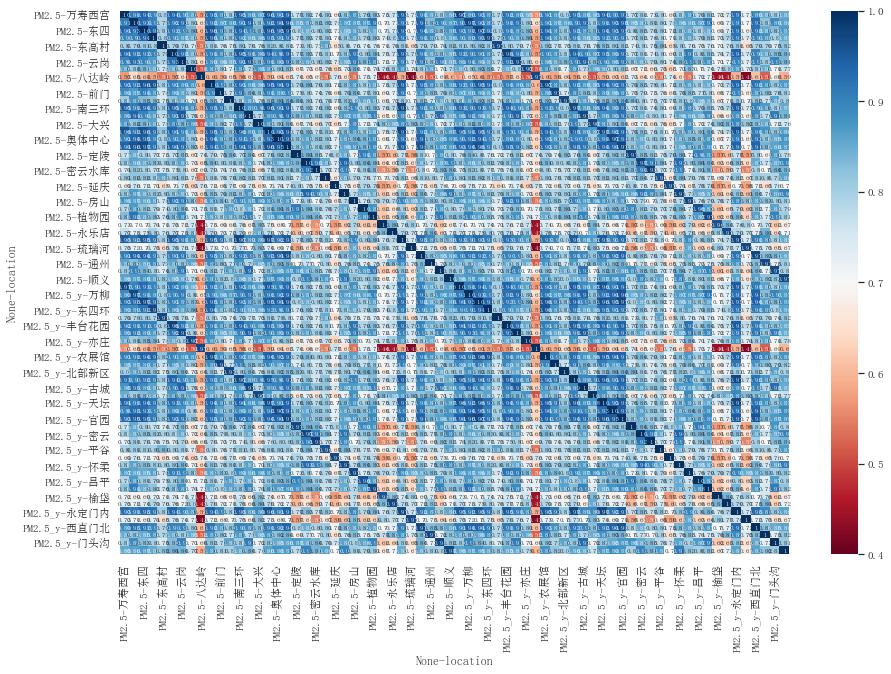

In [9]:
plt.figure(figsize=(15,10))
sns.set(font="SimSun")
sns.heatmap(round(corr,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1)

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

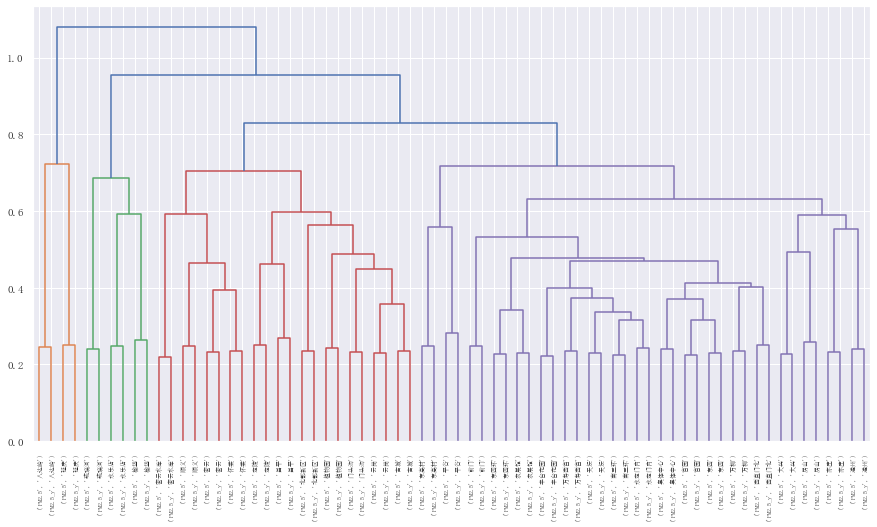

In [11]:
plt.figure(figsize=(15,8))
dissimilarity = np.sqrt(2*(1 - corr))
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=corr_data.columns, orientation='top', 
           leaf_rotation=90);

In [12]:
labels = fcluster(Z, t=4, criterion='maxclust')

labels_order = np.argsort(labels)

for idx, i in enumerate(corr_data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(corr_data[i])
    else:
        df_to_append = pd.DataFrame(corr_data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

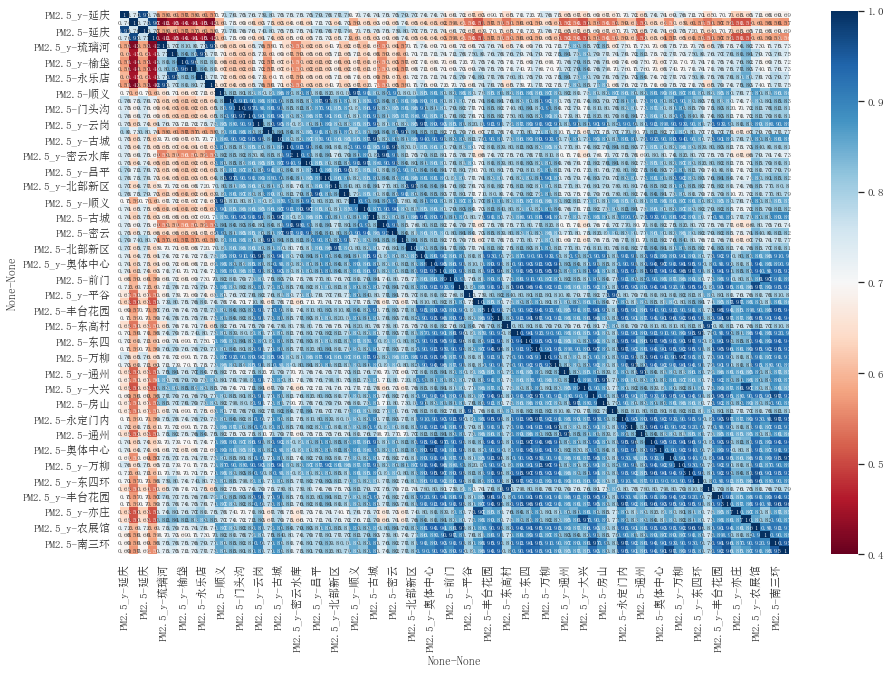

In [13]:
plt.figure(figsize=(15,10))
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1);

In [14]:
label_map = {c[1]:labels[i] for i,c in enumerate(corr_data.columns)}

In [15]:
def get_cluster_stats(labels,data):
    data = data.copy(deep=True)
    data['cluster'] = data['location'].map(lambda x: labels[x])
    tmp = data.groupby([data.index,'cluster'],as_index=False).mean()
    tmp = tmp.set_index(data.groupby([data.index,'cluster']).mean().index.get_level_values(0))
    newdf = pd.DataFrame()
    for c in set(tmp.cluster):
        cluster = tmp[tmp['cluster']==c]
        cluster.columns = [f'{col}_c{c}' for col in tmp.columns]
        newdf = pd.concat([newdf, cluster],axis=1)
    newdf = newdf[[col for col in newdf.columns if 'PM' in col]]
    newdf = pd.merge(newdf,data,left_index=True,right_index=True)
    newdf.drop(columns=['cluster'],inplace=True)
    del tmp
    gc.collect()
    return newdf

In [16]:
alldata = get_cluster_stats(label_map,alldata)

In [17]:
allTestdata = get_cluster_stats(label_map,allTestdata)

In [18]:
# alldata

In [19]:
# allTarget_noTS = pd.merge(alldata,allTarget,left_on=[alldata.index,'location'],right_on=[allTarget.index,'location'])[["PM2.5","location"]]

In [20]:
alldata_noTS = alldata.reset_index(drop=True)
# allTarget_noTS = allTarget.reset_index(drop=True)
allTarget_noTS = pd.merge(alldata,allTarget,left_on=[alldata.index,'location'],right_on=[allTarget.index,'location'])[["PM2.5","PM2.5_y","location"]]

In [21]:
#rearrange allTestTarget after clustering
allTestTarget['date'] = allTestTarget.index
allTestTarget = pd.merge(allTestdata,allTestTarget,left_on=[allTestdata.index,'location'],right_on=[allTestTarget.index,'location'])[["PM2.5","PM2.5_y","location","date"]]
allTestTarget = allTestTarget.set_index(allTestTarget.date)
allTestTarget = allTestTarget.drop(columns='date')

In [22]:
alldata_noTS['location'] = alldata_noTS['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noTS['location'].cat.categories ) )
alldata_noTS['location'] = alldata_noTS['location'].cat.codes
allTestdata['location'] = allTestdata['location'].astype('category')
allTestdata['location'] = allTestdata['location'].cat.codes

In [23]:
import lightgbm as lgb

In [24]:
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }


In [25]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)
#     predicted  = pd.DataFrame()
    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits

#         predicted = pd.concat([predicted,pd.DataFrame(y_pred_valid,index=subset_augmented.index[valid_index], columns=['predicted'])])
    #     print(predicted)

        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [26]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noTS,allTestdata,alldata_noTS['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	training's rmse: 13.9703	valid_1's rmse: 13.6795
val rmse score is 13.679455128621774
Fold: 2
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 11.4345	valid_1's rmse: 18.8345
Early stopping, best iteration is:
[620]	training's rmse: 11.0917	valid_1's rmse: 18.7673
val rmse score is 18.767307148807273
Fold: 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	training's rmse: 14.2619	valid_1's rmse: 13.2867
val rmse score is 13.286711298668044
Fold: 4
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 11.7201	valid_1's rmse: 18.3697
Early stopping, best iteration is:
[519]	training's rmse: 11.6607	valid_1's rmse: 18.3499
val rmse score is 18.349899745541972
Fold: 5
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 12.4067	valid_

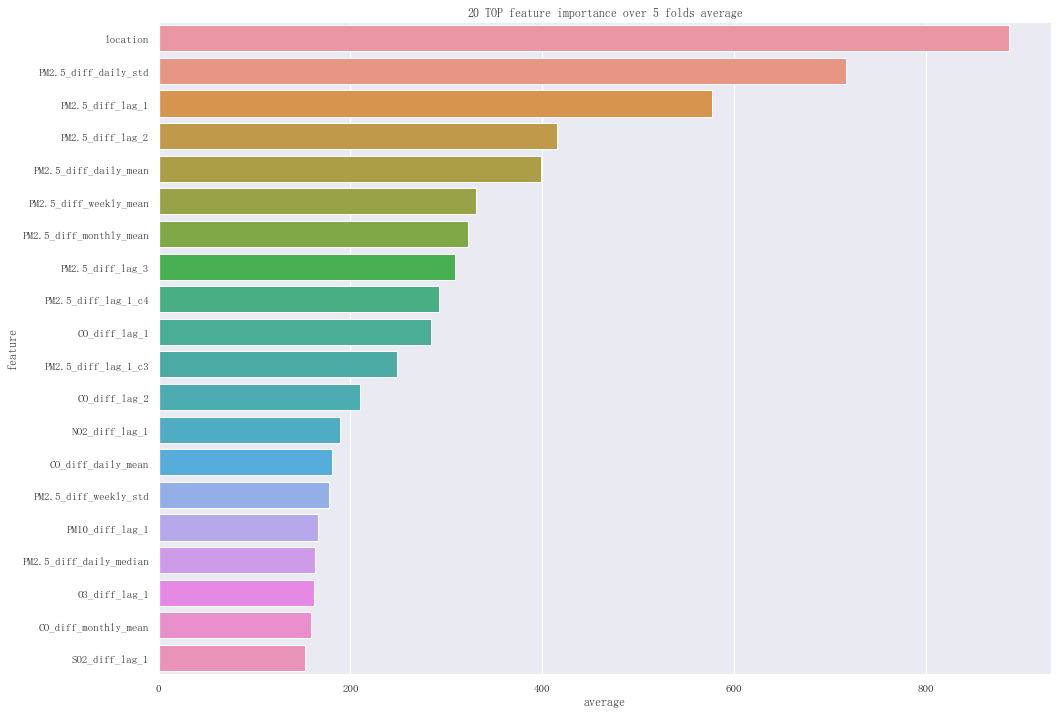

In [27]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(n_splits));

In [28]:
allTarget_noTS['predicted'] = predicted

In [29]:
allTarget_noTS

,PM2.5,PM2.5_y,location,predicted
0,15.4,NaN,东四,-2.385326
1,20.3,NaN,天坛,-3.080483
2,27.7,NaN,官园,-3.419606
3,16.4,NaN,万寿西宫,0.003804
4,62.1,NaN,奥体中心,-1.681196
...,...,...,...,...
816378,14.0,15.0,前门,2.896372
816379,16.0,12.0,永定门内,4.547595
816380,31.0,26.0,西直门北,-3.113730
816381,16.0,15.0,南三环,4.812819


In [30]:
# allTarget_noTS["PM2.5_y"] = allTarget_noTS['PM2.5'].shift(1)

allTarget_noTS['prediction'] = allTarget_noTS['predicted'] + allTarget_noTS['PM2.5_y']

# allTarget_noTS['prediction']=allTarget_noTS['prediction'].map(lambda x: np.exp(x))
# allTarget_noTS['PM2.5_y']=allTarget_noTS['PM2.5_y'].map(lambda x: np.exp(x))
# allTarget_noTS['PM2.5']=allTarget_noTS['PM2.5'].map(lambda x: np.exp(x))

allTarget_noTS = allTarget_noTS.dropna()

In [31]:
# allTarget_noTS['prediction']=allTarget_noTS['prediction'].map(lambda x: np.log(x))
# allTarget_noTS['PM2.5_y']=allTarget_noTS['PM2.5_y'].map(lambda x: np.log(x))
# allTarget_noTS['PM2.5']=allTarget_noTS['PM2.5'].map(lambda x: np.log(x))

In [32]:
# allTarget_noTS = allTarget_noTS.dropna()

In [33]:
print(f'light gbm rmse error is {np.sqrt(mean_squared_error(allTarget_noTS["prediction"],allTarget_noTS["PM2.5"]))}')
print(f'Naive model: use last hour to predict next hour {np.sqrt(mean_squared_error(allTarget_noTS["PM2.5_y"],allTarget_noTS["PM2.5"]))}')

light gbm rmse error is 15.679767509852244
Naive model: use last hour to predict next hour 19.529037218745973


In [34]:
allTarget_noTS

,PM2.5,PM2.5_y,location,predicted,prediction
35,15.4,15.4,东四,-1.745032,13.654968
36,27.2,20.3,天坛,-3.017967,17.282033
37,19.6,27.7,官园,-7.118066,20.581934
38,15.3,16.4,万寿西宫,-2.073434,14.326566
39,57.7,62.1,奥体中心,-3.210764,58.889236
...,...,...,...,...,...
816378,14.0,15.0,前门,2.896372,17.896372
816379,16.0,12.0,永定门内,4.547595,16.547595
816380,31.0,26.0,西直门北,-3.113730,22.886270
816381,16.0,15.0,南三环,4.812819,19.812819


In [35]:
allTarget_noTS.groupby(allTarget_noTS.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5)

location
万寿西宫    14.762302
万柳      13.565055
东四      14.179863
东四环     15.026837
东高村     14.979975
丰台花园    15.155150
云岗      14.647197
亦庄      18.787530
八达岭     11.646363
农展馆     14.779953
前门      17.982886
北部新区    14.501790
南三环     15.250290
古城      14.778310
大兴      18.140143
天坛      13.397996
奥体中心    14.185475
官园      13.156338
定陵      15.089440
密云      13.232726
密云水库    11.082397
平谷      16.147940
延庆      14.897828
怀柔      12.504163
房山      18.609253
昌平      14.634014
植物园     13.544573
榆垡      21.920666
永乐店     19.920459
永定门内    15.817615
琉璃河     22.817764
西直门北    16.012885
通州      17.855052
门头沟     13.024864
顺义      15.209929
dtype: float64

In [36]:
allTestTarget['predicted'] = test_predictions

In [37]:
allTestTarget

,PM2.5,PM2.5_y,location,predicted
date,,,,
2016-12-31 01:00:00,231.294118,NaN,东四,6.422068
2016-12-31 01:00:00,201.588235,NaN,万寿西宫,2.625876
2016-12-31 01:00:00,193.647059,NaN,农展馆,2.770377
2016-12-31 01:00:00,206.764706,NaN,丰台花园,3.181608
2016-12-31 01:00:00,205.882353,NaN,云岗,2.849468
...,...,...,...,...
2017-04-29 23:00:00,54.000000,56.0,前门,-2.371758
2017-04-29 23:00:00,52.000000,44.0,永定门内,-0.110128
2017-04-29 23:00:00,69.000000,74.0,西直门北,0.778327


In [38]:
# allTestTarget["PM2.5_y"] = allTestTarget['PM2.5'].shift(1)
allTestTarget['prediction'] = allTestTarget['predicted'] + allTestTarget['PM2.5_y']
# allTestTarget['prediction']=allTestTarget['prediction'].map(lambda x: np.exp(x))
# allTestTarget['PM2.5_y']=allTestTarget['PM2.5_y'].map(lambda x: np.exp(x))
# allTestTarget['PM2.5']=allTestTarget['PM2.5'].map(lambda x: np.exp(x))
allTestTarget = allTestTarget.dropna()

In [39]:
print(f'light gbm rmse error is {np.sqrt(mean_squared_error(allTestTarget["prediction"],allTestTarget["PM2.5"]))}')
print(f'Naive model: use last hour to predict next hour {np.sqrt(mean_squared_error(allTestTarget["PM2.5_y"],allTestTarget["PM2.5"]))}')

light gbm rmse error is 16.580490505288434
Naive model: use last hour to predict next hour 20.46211214252952


In [40]:
allTestTarget.groupby(allTestTarget.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5)

location
万寿西宫    19.179157
万柳      13.908421
东四      16.281113
东四环     14.492479
东高村     16.762319
丰台花园    13.825752
云岗      16.832908
亦庄      13.438999
八达岭     11.722867
农展馆     14.345740
前门      19.082009
北部新区    15.251858
南三环     19.049229
古城      16.843120
大兴      15.940835
天坛      13.906003
奥体中心    14.370635
官园      14.887257
定陵      12.967779
密云      12.564674
密云水库    10.296068
平谷      18.503053
延庆      15.254578
怀柔      14.864966
房山      17.726502
昌平      14.598011
植物园     13.692690
榆垡      30.361004
永乐店     17.970912
永定门内    18.392436
琉璃河     21.814362
西直门北    19.195139
通州      17.041910
门头沟     17.675274
顺义      14.565485
dtype: float64

In [41]:
allTestTarget

,PM2.5,PM2.5_y,location,predicted,prediction
date,,,,,
2016-12-31 02:00:00,236.576471,231.294118,东四,3.979027,235.273145
2016-12-31 02:00:00,206.352941,201.588235,万寿西宫,-0.101584,201.486652
2016-12-31 02:00:00,198.188235,193.647059,农展馆,0.801264,194.448322
2016-12-31 02:00:00,210.858824,206.764706,丰台花园,1.216818,207.981524
2016-12-31 02:00:00,210.529412,205.882353,云岗,0.667031,206.549384
...,...,...,...,...,...
2017-04-29 23:00:00,54.000000,56.000000,前门,-2.371758,53.628242
2017-04-29 23:00:00,52.000000,44.000000,永定门内,-0.110128,43.889872
2017-04-29 23:00:00,69.000000,74.000000,西直门北,0.778327,74.778327
